# Data Details
Source: Kaggle
Link: https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset

This dataset is having the data of 1K+ Amazon Product's Ratings and Reviews as per their details listed on the official website of Amazon

**Note**: Because the data is crawled from a website, there may be some inaccurate information. For example, the **rating_count** and the number of **user_id** reviewing a product may not be consistent with each other as well as it is not possible to know for sure whether the reviewers have actually purchased the product. Therefore, I will assume that the rating_count in this dataset represents the number of ratings from users who have made a purchase (or, as Amazon refers to them, **Verified Purchases**). This purpose will help me learn more throughout this project.

### Objective
We will answer the question related to dataset:
* **Q1**: What are the best-selling and worst-selling products?
* **Q2**: What is the impact of product discounts?
* **Q3**: Which product categories perform the best and the worst?
* **Q4**: What are the Top 10 popular product?
* **Q5**: What are the Top 10 worst product?

Moreover, We will build a recommendation systems (Content-based Recommendation)
### Product Features
* product_id - Product ID
* product_name - Name of the Product
* category - Category of the Product
* discounted_price - Discounted Price of the Product
* actual_price - Actual Price of the Product
* discount_percentage - Percentage of Discount for the Product
* rating - Rating of the Product
* rating_count - Number of people who voted for the Amazon rating (Verified Purchases)
* about_product - Description about the Product
* img_link - Image Link of the Product
* product_link - Official Website Link of the Product
### User & Review Features
* user_id - ID of the user who wrote review for the Product
* user_name - Name of the user who wrote review for the Product
* review_id - ID of the user review
* review_title - Short review
* review_content - Long review


# Import Library

In [3]:
import pandas as pd
import numpy as np

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#Model
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data

In [5]:
df = pd.read_csv("amazon.csv")

In [6]:
df.shape

(1465, 16)

# Preparation and Cleaning Data

### Dealing with missing value & remove duplicated value

In [9]:
# Check Nan in Dataset. We discovered that the rating_count column has missing values. We will process this.
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [10]:
# Find product has missing value. We have 2 item. 
df[df['rating_count'].isnull()]

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹999,80%,3.0,NaN,USB C to C Cable: This cable has type C connec...,AE7CFHY23VAJT2FI4NZKKP6GS2UQ,Pranav,RUB7U91HVZ30,The cable works but is not 65W as advertised,I have a pd supported car charger and I bought...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Amazon-Brand-Charging-Su...
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,₹249,₹999,75%,5.0,NaN,💎[The Fastest Charge] - This iPhone USB C cabl...,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...


Because I can't find the product id in amazon.in to fill specific value. So I decide to remove them.

In [12]:
df = df.dropna()

In [13]:
# Check Duplicated Value. We don't have duplicated value
df.duplicated().sum()

0

### Convert data types


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1463 non-null   object
 1   product_name         1463 non-null   object
 2   category             1463 non-null   object
 3   discounted_price     1463 non-null   object
 4   actual_price         1463 non-null   object
 5   discount_percentage  1463 non-null   object
 6   rating               1463 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1463 non-null   object
 9   user_id              1463 non-null   object
 10  user_name            1463 non-null   object
 11  review_id            1463 non-null   object
 12  review_title         1463 non-null   object
 13  review_content       1463 non-null   object
 14  img_link             1463 non-null   object
 15  product_link         1463 non-null   object
dtypes: object(1

Most variables in the dataset have an object (string) data type. To conduct numerical analyses on these variables, they must be converted into numeric formats.Specifically, The price (discounted,actual) columns need to have the symbols removed before they can be converted to float.

In [17]:
df_copy = df.copy()

In [18]:
df_copy['rating'].value_counts() # Have unusual value (|)

rating
4.1    244
4.3    230
4.2    228
4.0    129
3.9    123
4.4    123
3.8     86
4.5     75
4       52
3.7     42
3.6     35
3.5     26
4.6     17
3.3     16
3.4     10
4.7      6
3.1      4
4.8      3
3.2      2
2.8      2
3.0      2
5.0      2
2.3      1
|        1
2        1
3        1
2.6      1
2.9      1
Name: count, dtype: int64

In [19]:
df_copy['discounted_price'] = df_copy['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)

df_copy['actual_price'] = df_copy['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

df_copy['discount_percentage'] = df_copy['discount_percentage'].str.replace('%', '').astype(float)/100

df_copy['rating_count'] = df_copy['rating_count'].str.replace(',','').astype(int)

# Fill unusual value (|) in rating column and change data type of rating & rating_count column
df_copy['rating'] = df_copy['rating'].replace('|',b'3.9')
df_copy['rating'] = df_copy['rating'].astype(float)

I searched for products on the **Amazon.in** website and found a product with a **rating** of 3.9 (It may vary slightly between this time and the past, but the difference will not be significant)

Next, I will process the **Category** column because I see that it currently combines both major and minor product classifications. By separating them, we will have a clearer view of each category.

In [22]:
df_copy['Main Category'] = df_copy['category'].str.split('|').str.get(0)
df_copy['Sub Category'] = df_copy['category'].str.split('|').str.get(1)
df_copy['product_type'] = df_copy['category'].str.split('|').str.get(-1)
df_copy = df_copy.drop(columns = 'category')

### Clean and preprocess the text.

In [24]:
# Cleaning and preprocessing text without lemmatization
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Split text into words and rejoin without stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Assuming df is your DataFrame and it has been previously loaded
# Apply the clean_text function to the DataFrame columns
df_copy['product_name'] = df_copy['product_name'].apply(clean_text)
df_copy['about_product'] = df_copy['about_product'].apply(clean_text)
df_copy['review_content'] = df_copy['review_content'].apply(clean_text)

**Now**, I will only select the columns with analytical value, to focus on the important information and eliminate irrelevant data, making the analysis process more accurate and efficient.

In [26]:
df_product = df_copy[["product_id","product_name","discounted_price","actual_price","discount_percentage","Main Category",
                    "Sub Category","product_type","rating","rating_count","about_product"]]

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_product.insert(0, 'ProdID', le.fit_transform(df_product['product_id']))

df_product= df_product.drop(columns = 'product_id')

In the user_id column, it can be observed that it is a list of user IDs, meaning all the IDs of users who commented on the product are recorded in this column (in this dataset, the number of IDs may not reflect reality). I will proceed to split these user IDs into separate rows.

In [29]:
df_user = df_copy[["user_id","product_id","product_name","actual_price","Main Category",
                   "about_product",'rating']]

In [30]:
length_user_list = df_user["user_id"].str.split(",").apply(len)
split_user = df_user["user_id"].str.split(",").explode(ignore_index = True)

# Bởi vì tôi đã tách những giá trị userid ra riêng nên những cột có liên quan tới cũng cần được 
product_ids = df_user['product_id'].repeat(length_user_list).reset_index(drop=True)
product_name = df_user['product_name'].repeat(length_user_list).reset_index(drop=True)
about_prod = df_user['about_product'].repeat(length_user_list).reset_index(drop=True)
mcate = df_user['Main Category'].repeat(length_user_list).reset_index(drop=True)
rating = df_user['rating'].repeat(length_user_list).reset_index(drop=True)

In [31]:
df_user = pd.DataFrame({'user_id': split_user,
                        'prod_id': product_ids,
                        'Product name': product_name,
                        'Rating': rating,
                        'About Product':about_prod,
                        'Main Category': mcate
                       })

# Descriptive Analysis

In [33]:
df_copy.describe()

,discounted_price,actual_price,discount_percentage,rating,rating_count
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000
mean,3129.277122,5451.068544,0.476507,4.096582,18295.541353
std,6948.222850,10881.018448,0.216224,0.289444,42753.864952
min,39.000000,39.000000,0.000000,2.000000,2.000000
25%,325.000000,800.000000,0.320000,4.000000,1186.000000
50%,799.000000,1690.000000,0.500000,4.100000,5179.000000
75%,1999.000000,4312.500000,0.630000,4.300000,17336.500000
max,77990.000000,139900.000000,0.940000,5.000000,426973.000000


## Correlation Matrix

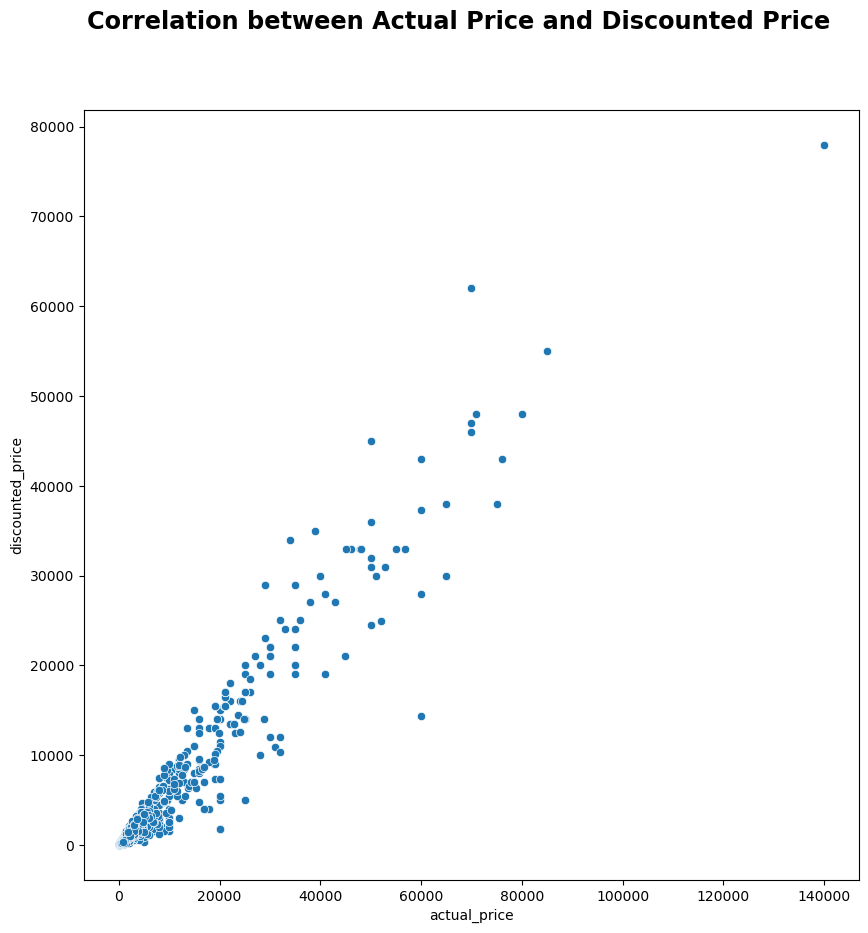

In [35]:
fig,ax = plt.subplots(figsize = (10,10))
fig.suptitle('Correlation between Actual Price and Discounted Price', fontweight='heavy', size='xx-large')

sns.scatterplot( data = df_product, x = 'actual_price', y = 'discounted_price');
    

The strong correlation between these two variables indicates that the discounted price largely depends directly on the actual price. This suggests that discounts are often determined based on a fixed percentage or a specific reduction from the original price.

# Exploratory Data Analysis (EDA) & Data Visualization

## Observation 1: Product Category

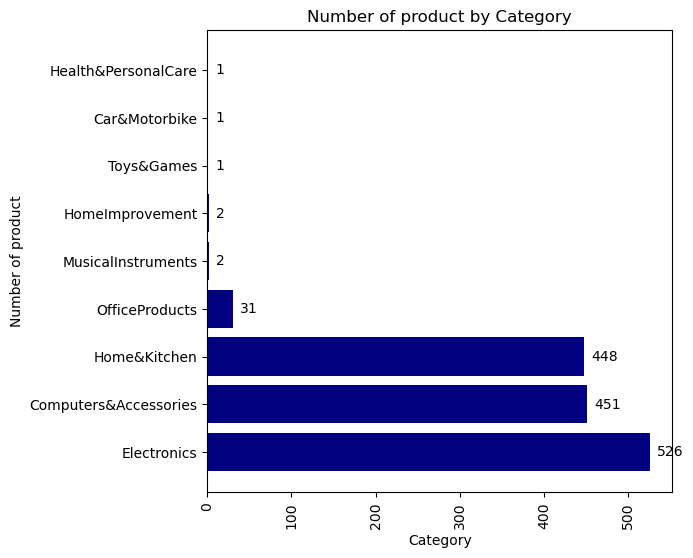

In [39]:
# Visualize number of each Main category
count_cate = df_product['Main Category'].value_counts()
fig, ax = plt.subplots(figsize = (6,6))

plt.xticks(rotation = 90)
ax.barh(count_cate.index,count_cate.values,color = 'navy')
ax.set(title = 'Number of product by Category', xlabel = 'Category' ,ylabel = 'Number of product');

for barh in ax.patches:
    ax.annotate(format(barh.get_width(), '.0f'),  
                (barh.get_width(), barh.get_y() + barh.get_height() / 2),
                ha='left', va='center', 
                xytext=(5, 0),  
                textcoords='offset points') 

The chart showed:
* Electronics, Computer&Accessories and HomeKitchen cover most of the products. This shows that these categories are popular with customer.
* For the remaining categories with fewer products, this could be due to low shopping demand on the e-commerce platform or (due to limited data).

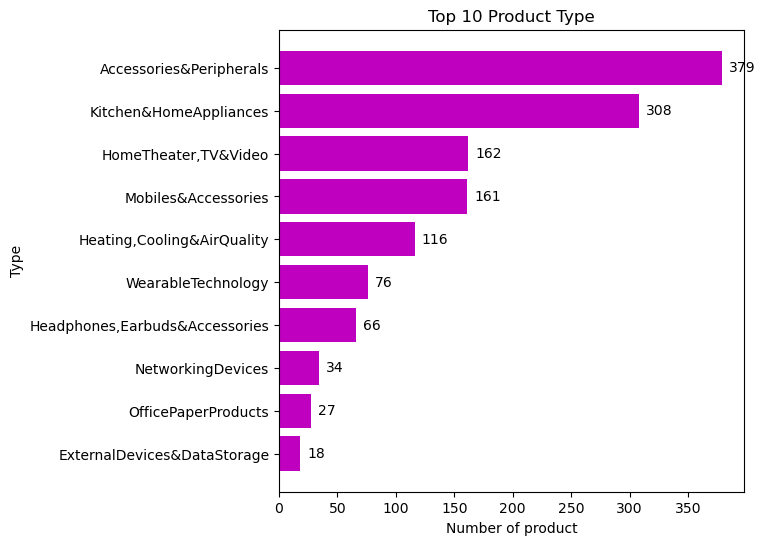

In [41]:
count_subcate = df_product['Sub Category'].value_counts().sort_values(ascending = True).tail(10)
fig, ax = plt.subplots(figsize = (6,6))
ax.barh(count_subcate.index,count_subcate.values,color = 'm')
ax.set(title = 'Top 10 Product Type', xlabel = 'Number of product' ,ylabel = 'Type');

for barh in ax.patches:
    ax.annotate(format(barh.get_width(), '.0f'),  
                (barh.get_width(), barh.get_y() + barh.get_height() / 2),
                ha='left', va='center', 
                xytext=(5, 0),  
                textcoords='offset points') 

**Accessories & Peripherals and Kitchen & Home Appliances** are the two product categories with the most items, showing high demand and competition in these areas. This gives e-commerce platforms and sellers a chance to focus on these categories to provide better products for customers. Moreover, they can also apply new strategies or improve the products that are becoming more popular.

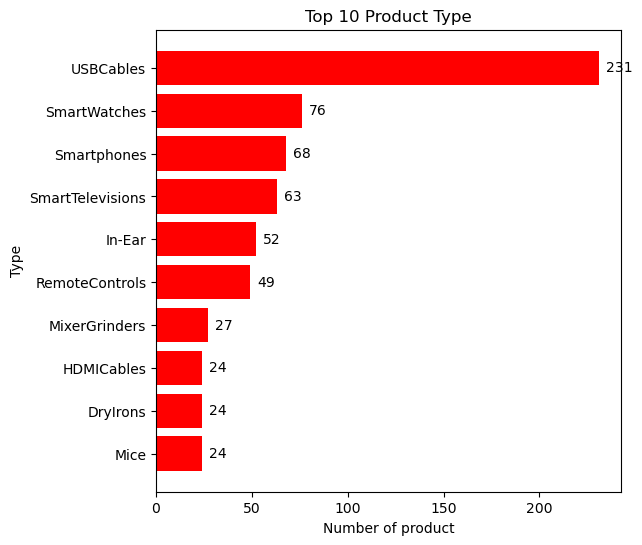

In [43]:
count_ptype = df_product['product_type'].value_counts().sort_values(ascending = True).tail(10)
fig, ax = plt.subplots(figsize = (6,6))

ax.barh(count_ptype.index,count_ptype.values,color = 'r')
ax.set(title = 'Top 10 Product Type', xlabel = 'Number of product' ,ylabel = 'Type');

for barh in ax.patches:
    ax.annotate(format(barh.get_width(), '.0f'),  
                (barh.get_width(), barh.get_y() + barh.get_height() / 2),
                ha='left', va='center', 
                xytext=(5, 0),  
                textcoords='offset points') 

* Top 5 sản phẩm USB cable, watches, smartphone,...có nhiều sản phẩm nhất. Cho thấy nhu cầu cao từ khách hàng và giúp cho sàn thương mại cũng như người bán có thể tập trung vào phân khúc này để có nhiều sản phẩm tốt hơn để phục vụ đến khách hàng.
* Đối với những category khác (MixerGrinders,HDMI cable, Dry Iron,...) cũng chiếm lượng sản phẩm ổn định và cần được cải thiện thêm

### Q4: Top 10 Most Popular Products

In [46]:
top_popular_product = df_product[(df_product['rating']>=4.1)].sort_values(by = "rating_count",ascending = False).head(10)
top_popular_product = top_popular_product[['product_name','rating','rating_count']]
top_popular_product

,product_name,rating,rating_count
47,amazon basics highspeed hdmi cable 6 feet supp...,4.4,426973
12,amazonbasics flexible premium hdmi cable black...,4.4,426973
65,amazon basics highspeed hdmi cable 6 feet 2pac...,4.4,426973
684,amazonbasics flexible premium hdmi cable black...,4.4,426972
352,boat bassheads 100 ear wired earphones mictaff...,4.1,363713
400,boat bassheads 100 ear wired earphones micfuri...,4.1,363713
584,boat bassheads 100 inear wired headphones mic ...,4.1,363711
371,redmi 9a sport coral green 2gb ram 32gb storag...,4.1,313836
370,redmi 9 activ carbon black 4gb ram 64gb storag...,4.1,313836
473,redmi 9a sport carbon black 2gb ram 32gb stora...,4.1,313832



* **Focus on best-selling products:** By identifying popular products, the marketplace can focus on promoting and maintaining stock for these items, thereby maximizing revenue.

* **Understand market demand:** Identifying popular products helps the marketplace understand consumer trends and preferences, enabling them to adjust or expand the product range to better meet customer needs.

### Q5: Top 10 Most Worst Products

In [49]:
top_worst_product = df_product[(df_product['rating']< 3)].sort_values(by = "rating_count").head(10)
top_worst_product = top_worst_product[['product_name','rating','rating_count']]
top_worst_product

,product_name,rating,rating_count
1309,khaitan orfin fan heater home kitchenk0 2215,2.0,2
1243,personal size blender portable blender battery...,2.3,13
1356,green tales heat seal mini food sealerimpulse ...,2.6,24
545,shreenova id116 plus bluetooth fitness smart w...,2.8,87
1286,mr brand portable usb juicer electric usb juic...,2.8,109
1449,ionix tap filter multilayer activated carbon f...,2.9,159


* **Identifying bad products**: helps Amazon control the quality of the products in order to improve product quality and enhance customer experience.

## Observation 2: Rating Distribution

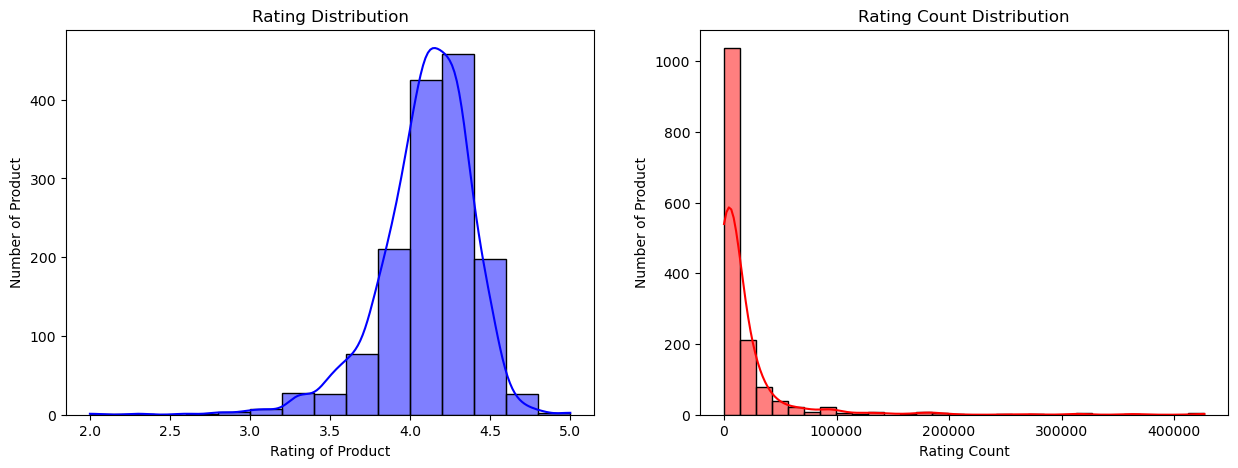

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(ax = ax[0], data=df_product, x='rating', bins= 15, kde=True, color='blue')
sns.histplot(ax = ax[1], data=df_product, x='rating_count', bins= 30, kde=True, color='red')
ax[0].set(title = 'Rating Distribution',xlabel = 'Rating of Product',ylabel = 'Number of Product')
ax[1].set(title = 'Rating Count Distribution',xlabel = 'Rating Count',ylabel = 'Number of Product');

Through these two histogram, we can see that: 

* For the Rating Figure, most product ratings are between 4.0 and 4.35 as well as no product rating below 2.0. The rating distribution tends to be **left-skewed** that means most of products are rated highly 

* Most products have fewer than 10,000 ratings. A few products have a very high number of ratings (over 100,000), creating a long tail on the right, indicating a **highly right-skewed trend**.

In [54]:
bins = [0,1,2,3,4,5]
pd.cut(df_product['rating'], bins=bins, include_lowest=True, labels=['0-1', '1-2', '2-3', '3-4', '4-5']).value_counts()

rating
4-5    928
3-4    526
2-3      8
1-2      1
0-1      0
Name: count, dtype: int64

In [55]:
df_product.groupby(['Main Category',"Sub Category"])["rating"].mean()

Main Category          Sub Category                           
Car&Motorbike          CarAccessories                             3.800000
Computers&Accessories  Accessories&Peripherals                    4.149340
                       Components                                 4.380000
                       ExternalDevices&DataStorage                4.316667
                       Laptops                                    4.000000
                       Monitors                                   4.250000
                       NetworkingDevices                          4.155882
                       Printers,Inks&Accessories                  3.963636
                       Tablets                                    4.600000
Electronics            Accessories                                4.335714
                       Cameras&Photography                        4.125000
                       GeneralPurposeBatteries&BatteryChargers    4.350000
                       Headphones,Ear

Most categories have a rating of 4.0 or higher. However, there are still a few categories that need improvement:

Specifically, in the **Electronics** category, the **Headphones, Earbuds & Accessories** subcategory has a relatively lower average rating compared to other products in the same category. Addressing this issue could help improve the overall quality.

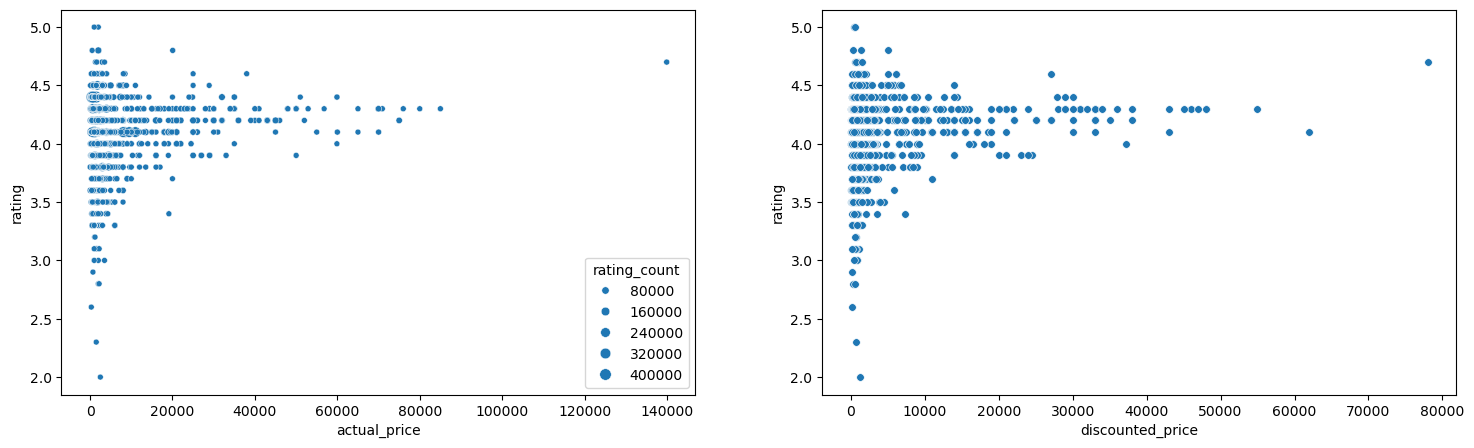

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (18,5))

sns.scatterplot(ax = ax[0], data = df_product, x = 'actual_price', y = 'rating',size = 'rating_count', s=30)

sns.scatterplot(ax = ax[1],data = df_product,  x = 'discounted_price', y = 'rating',s=30)
plt.show()

Through these two scatter plots, we can see that: 

* **Actual Price vs Rating:** There is a wide distribution of ratings across different price ranges. Higher-priced products tend to receive a moderate to high number of ratings, suggesting that consumers are engaged with products across all price ranges.

* **Discounted Price vs Rating:** Similar to the actual price, the discounted price also shows a broad distribution of ratings. It indicates that discounted prices do not significantly bias the average ratings, suggesting that consumers are rating based on product quality and satisfaction rather than just price.

# Recommendation System (Item-based Recommendation)

In [62]:
df_user.insert(0, 'ProdID', le.fit_transform(df_user['prod_id']))
df_user.insert(0, 'UserID', le.fit_transform(df_user['user_id']))

df_user = df_user.drop(columns = ['user_id','prod_id'])


In [63]:
df_user['Tags'] =  df_user["Main Category"] + " "+ df_user["About Product"]
def recommendation_with_category_filter(df, user_id_encoded, top_n=5):
    df['Tags'] = df['Tags'].str.lower()
    tfidf = TfidfVectorizer(stop_words='english',ngram_range = (1,1))
    tfidf_matrix = tfidf.fit_transform(df['Tags'])
    
    # Lấy lịch sử mua hàng của người dùng
    user_history = df[df['UserID'] == user_id_encoded]
    indices = user_history.index.tolist()
    if user_history.empty:
        print("No purchase history found.")
        return None
    
    # Lọc các sản phẩm trong cùng Main Category
    user_main_category = df.iloc[indices[0]]['Main Category']
    recommend_list = df[df['Main Category'] == user_main_category]
    
    # Lấy danh sách các sản phẩm chưa mua
    recommend_list = recommend_list[~recommend_list['ProdID'].isin(user_history['ProdID'])]
    recommend_list = recommend_list.drop(columns=['UserID']).drop_duplicates()
    indices_recommend = recommend_list.index.tolist()
    
    # Tính độ tương đồng cosine
    cosine_sim_user = cosine_similarity(tfidf_matrix[indices], tfidf_matrix[indices_recommend])
    
    # Áp dụng bộ lọc ưu tiên Main Category
    similarity_scores = [(indices_recommend[i], cosine_sim_user[0][i]) for i in range(len(indices_recommend))]
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    top_products = [df.iloc[i[0]]['Product name'] for i in similarity_scores[:top_n]]
    top_scores = [i[1] for i in similarity_scores[:top_n]]
    top_prodid = [df.iloc[i[0]]['ProdID'] for i in similarity_scores[:top_n]]
    rating = [df.iloc[i[0]]['Rating'] for i in similarity_scores[:top_n]]
    
    recommended_df = pd.DataFrame({
        'ProID': top_prodid,
        'Product': top_products,
        'Rating': rating,
        'Similarity Score': top_scores
    })

    print(recommended_df)


In [100]:
Recommend_UserID = int(input("Type userid:"))
print("List recommended product:")
recommendation_with_category_filter(df_user,Recommend_UserID) 

Type userid: 7656


List recommended product:
   ProID                                            Product  Rating  \
0    426  lifelong llmg74 750 watt mixer grinder 3 jars ...     3.8   
1   1315  ibell induction cooktop 2000w auto shut overhe...     4.2   
2   1094  ibell sm1301 3in1 sandwich maker detachable pl...     4.3   
3   1221  ibell sm1515new sandwich maker floating hinges...     4.1   
4   1077  crompton instabliss 3l instant water heater ge...     4.1   

   Similarity Score  
0          0.461286  
1          0.267491  
2          0.234694  
3          0.164451  
4          0.151436  
